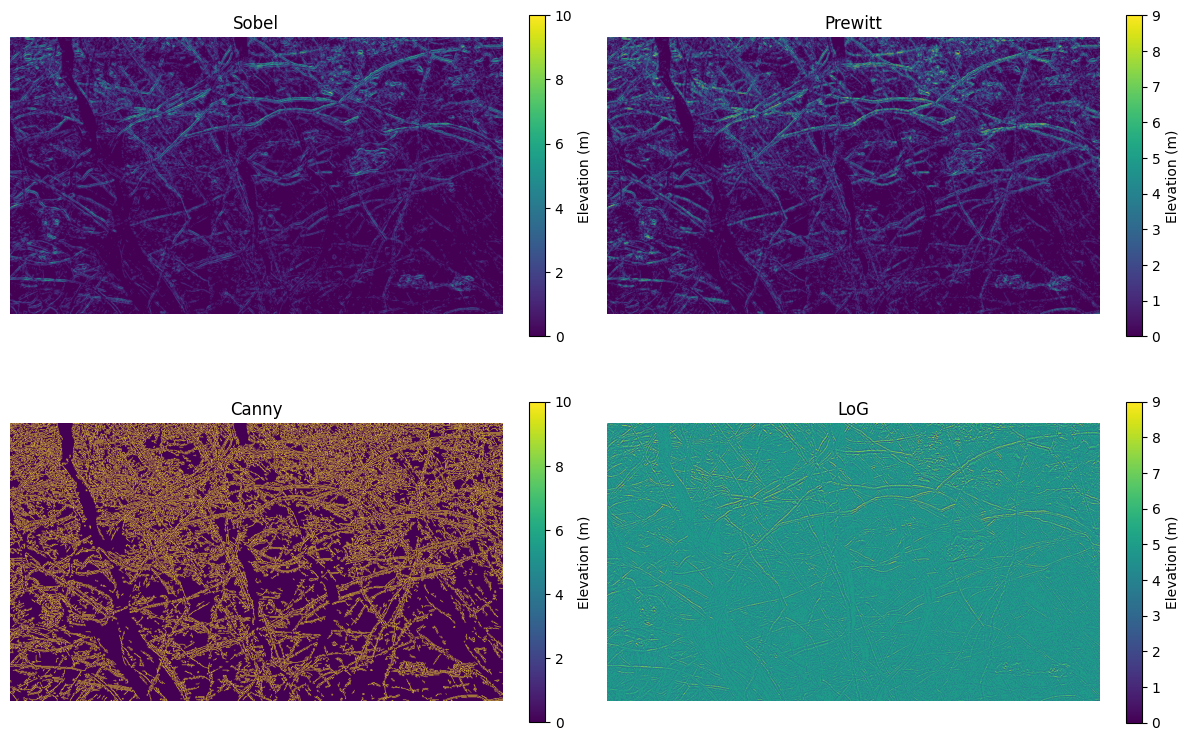

In [172]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Load citra grayscale
img = cv2.imread(r"europa_map\raw\borvo_mensa.jpg", cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- 1. SOBEL ---
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
sobel = cv2.magnitude(sobel_x, sobel_y)
H_sobel = cv2.normalize(sobel, None, 0, 10, cv2.NORM_MINMAX)


# --- 2. PREWITT (manual kernel) ---
prewitt_kernel_x = np.array([[1,0,-1], [1,0,-1], [1,0,-1]])
prewitt_kernel_y = np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
prewitt_x = ndimage.convolve(img.astype(float), prewitt_kernel_x)
prewitt_y = ndimage.convolve(img.astype(float), prewitt_kernel_y)
prewitt = np.hypot(prewitt_x, prewitt_y)
H_prewitt = cv2.normalize(prewitt, None, 0, 10, cv2.NORM_MINMAX)

# --- 3. CANNY ---
canny = cv2.Canny(img, 100, 200)
H_canny = cv2.normalize(canny, None, 0, 10, cv2.NORM_MINMAX)

# --- 4. LAPLACIAN OF GAUSSIAN (LoG) ---
blurred = cv2.GaussianBlur(img, (3, 3), 0)
log = cv2.Laplacian(blurred, cv2.CV_64F)
H_log = cv2.normalize(log, None, 0, 10, cv2.NORM_MINMAX)

# --- Plotting Semua ---
titles = ['Sobel', 'Prewitt', 'Canny', 'LoG']
h = [H_sobel, H_prewitt, H_canny, H_log]

plt.figure(figsize=(12, 8))
for i in range(len(h)):
    axs = plt.subplot(2, 2, i+1)
    plt.imshow(np.uint8(np.abs(h[i])), cmap='viridis')
    plt.title(titles[i])
    plt.axis("off")
    plt.colorbar(label="Elevation (m)", fraction=0.03)
plt.tight_layout()
plt.show()


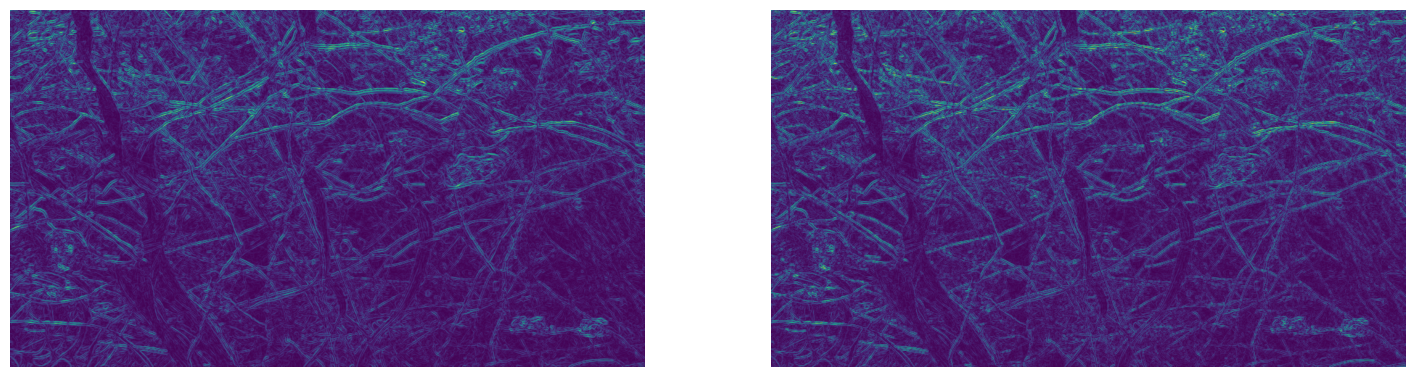

In [173]:
plt.figure(figsize=(18,6))
for i, j in enumerate([H_sobel, H_prewitt]):
    plt.subplot(1, 2, i+1)
    plt.imshow(j, cmap='viridis')
    plt.axis('off')
plt.tight_layout
plt.show()

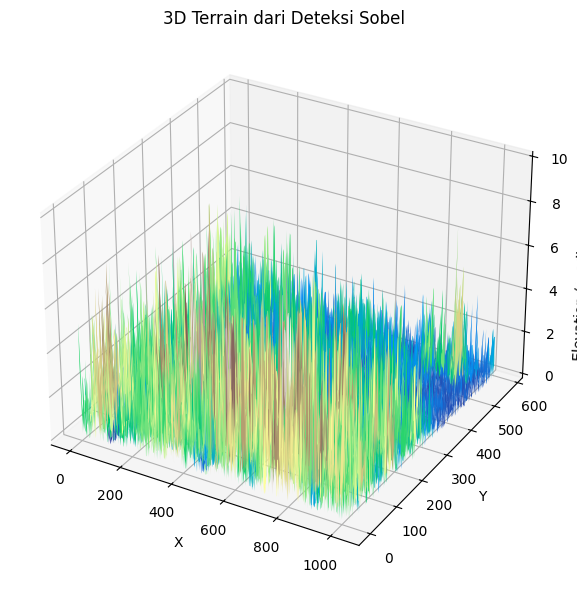

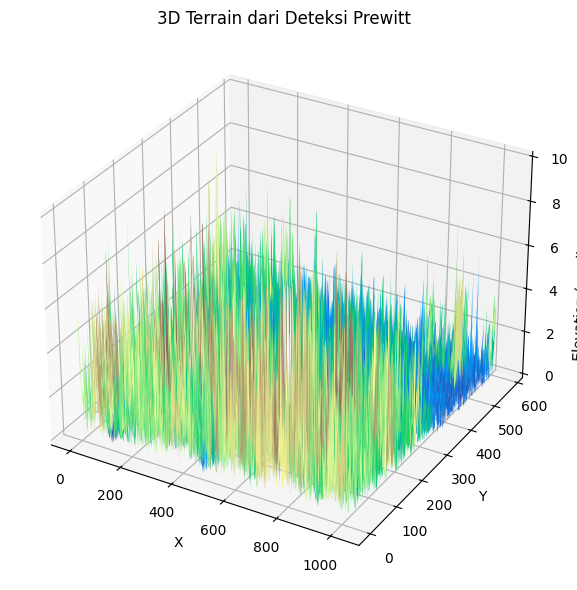

In [174]:

# --- 3D Terrain Function ---
def plot_3d(data, title):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    X = np.arange(data.shape[1])
    Y = np.arange(data.shape[0])
    X, Y = np.meshgrid(X, Y)

    ax.plot_surface(X, Y, data, cmap='terrain', edgecolor='none', antialiased=True)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Elevation (gradient intensity)')
    plt.tight_layout()
    plt.show()

# --- Tampilkan Terrain 3D ---
plot_3d(H_sobel, "3D Terrain dari Deteksi Sobel")
plot_3d(H_prewitt, "3D Terrain dari Deteksi Prewitt")


In [185]:
import cv2
import numpy as np
import plotly.graph_objs as go

# Load citra grayscale dan resize
img = cv2.imread(r'europa_map/raw/borvo_mensa.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (300, 300))  # Ukuran sedang untuk responsif
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

gray_blurred = cv2.GaussianBlur(gray, (9, 9), sigmaX=2)

# --- Step 2: Sobel Gradient Magnitude (Gx, Gy) ---
sobelx = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=3)
magnitude = cv2.magnitude(sobelx, sobely)

# --- Step 3: Normalize to Elevation Range (0 - 30 meters) ---
H_sobel = cv2.normalize(magnitude, None, 0, 30, cv2.NORM_MINMAX)

# --- Step 4: Post-Smooth the Elevation Map to Reduce Spikes ---
H_sobel = cv2.GaussianBlur(H_sobel, (5, 5), sigmaX=1.2)
# Normalisasi nilai untuk ditampilkan sebagai elevasi
sobel_normalized = cv2.normalize(H_sobel, None, alpha=0, beta=255,
                                 norm_type=cv2.NORM_MINMAX).astype(np.uint8)

# --- Buat Plotly 3D Surface ---
fig = go.Figure(data=[go.Surface(
    z=sobel_normalized,
    colorscale='Earth',  # Warna peta kontur
    showscale=True
)])

fig.update_layout(
    title='3D Interaktif Terrain dari Deteksi Sobel',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Elevation (gradient)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.0))
    ),
    margin=dict(l=10, r=10, b=10, t=40),
    height=600
)

# Tampilkan
fig.write_html("terrain_sobel.html")
